In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
min_date = session.query(Measurement.date).order_by(Measurement.date).first()
min_date

('2010-01-01')

In [11]:
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date

('2017-08-23')

In [12]:
max_date_dt = pd.to_datetime(max_date)
max_date_dt

DatetimeIndex(['2017-08-23'], dtype='datetime64[ns]', freq=None)

In [13]:
year_ago = max_date_dt - dt.timedelta(days=365)
year_ago

DatetimeIndex(['2016-08-23'], dtype='datetime64[ns]', freq=None)

In [14]:
year_ago_str = year_ago.strftime("%Y-%m-%d")[0]
year_ago_str

'2016-08-23'

In [15]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [16]:
engine.execute('SELECT * FROM measurement LIMIT 5').keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [17]:
engine.execute('SELECT * FROM station LIMIT 5').keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [19]:
df = pd.read_sql_query('SELECT * FROM station LIMIT 10', session.bind.engine)
df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [20]:
df_mes = pd.read_sql_query('SELECT * FROM measurement LIMIT 10', session.bind.engine)
df_mes.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [
       
       (Measurement.date).label("Date"), 
       (Measurement.prcp).label("Percipitation"), 
       ]

# Calculate the date 1 year ago from the last data point in the database
prcp = session.query(*sel).\
    filter(Measurement.date >= year_ago_str).\
    order_by(Measurement.date).statement

# f: Load the results into a pandas dataframe. Set the index to the `date`
prcp_df = pd.read_sql_query(prcp,session.bind.engine )

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df.set_index('Date').head()


,Percipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [22]:
# Sort the dataframe by date
sorted_df = prcp_df.sort_values("Date")
sorted_df.head()



,Date,Percipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [23]:
len(sorted_df)

2230

In [24]:
df_graph = prcp_df[["Date", "Percipitation"]]
df_graph= df_graph.dropna()
df_graph.head()

,Date,Percipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


In [25]:
len(df_graph)

2021

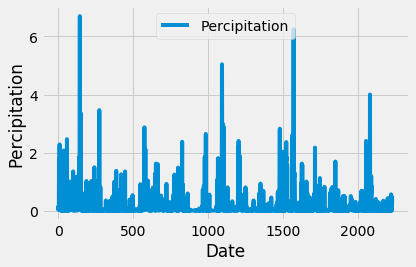

In [26]:

# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(10, 5))
plt.style.use('fivethirtyeight')
df_graph.plot()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Percipitation")
plt.legend(loc = "upper center")
plt.tight_layout()
plt.show()


In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [28]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [29]:
station_count = session.query(func.count(distinct(Measurement.station)))
station_count.all()

[(9)]

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by (func.count(Measurement.station).desc())
active_stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_sel = [
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs),
             func.max(Measurement.tobs)]

active_highest_station = session.query(Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()

active_highest_station_str = active_highest_station[0]

active_station = session.query(*active_sel).\
                filter(Measurement.station == active_highest_station_str).\
                all()

active_station

[(54.0, 71.66378066378067, 85.0)]

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_sel = [(Measurement.station).label("Station"), 
       (Measurement.tobs).label("TOBS")]

highest_station = session.query(*highest_sel).\
                filter(Measurement.date >= year_ago_str).\
                filter(Measurement.station == active_highest_station_str).\
                order_by(Measurement.date).\
                statement
highest_station


<sqlalchemy.sql.annotation.AnnotatedSelect at 0x121f72be0; AnnotatedSelect object>

In [33]:
df_highest_station_all = pd.read_sql_query(highest_station, session.bind.engine)
df_highest_station_all = df_highest_station_all.dropna()
df_highest_station_all.head()

,Station,TOBS
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


<Figure size 1440x720 with 0 Axes>

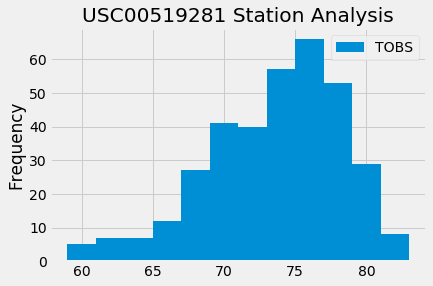

In [34]:
n_bins  = 12

plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
df_highest_station_all.plot.hist(bins = n_bins)
plt.grid(True)
plt.ylabel("Frequency")
plt.title("USC00519281 Station Analysis")
#plt.legend('tobs', loc = "upper center")
plt.show()

### Climate App

In [35]:
#Use FLASK to create your routes.

from flask import Flask, jsonify

In [36]:
app = Flask(__name__)

In [37]:
# @app.route("/api/v1.0/precipitation")
# def precipitation():
#     session = Session(engine)
#     sel = [
       
#        (Measurement.date).label("Date"), 
#        (Measurement.prcp).label("Percipitation"), 
#        ]
#     max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#     max_date_dt = pd.to_datetime(max_date)
#     year_ago = max_date_dt - dt.timedelta(days=365)
#     year_ago_str = year_ago.strftime("%Y-%m-%d")[0]
#     prcp = session.query(*sel).\
#        filter(Measurement.date >= year_ago_str).\
#        order_by(Measurement.date).\
#        all()
#     p_dict = dict(prcp)
#     #print()
#     #print("Results for Precipitation")
#     return jsonify(p_dict)

In [40]:
# @app.route("/api/v1.0/stations")
# def station():
    
#     station_totals = session.query(Station.station)\
#     .order_by(Station.station).all() 
#     print()
#     print("Station List:")   
#     for row in station_totals:
#         print (row[0])
#     return jsonify(station_totals)
# @app.route("/api/v1.0/tobs")
# def tobs():
    
#     temp_obs = session.query(Measurement.tobs)\
#     .order_by(Measurement.date).all()
#     print()
#     print("Temperature Results for All Stations")
#     return jsonify(temp_obs)

# @app.route("/api/v1.0/<start_date>")
# def start(start_date):
#     session = Session(engine)
#     sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
#     result = session.query(*sel).\
#               filter(Measurement.date >= '2015-06-15').\
#               all()
#     return jsonify(result)

In [44]:
# @app.route("/api/v1.0/<start_date>/<end_date>")
# def start_end(start_date, end_date):
#        session = Session(engine)
       
#        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
       
#        result = session.query(*sel).\
#               filter(Measurement.date >= '2015-06-15').\
#               filter(Measurement.date <= '2015-06-30').\
#               group_by(Measurement.date).\
#               all()
       
#        return jsonify(result)

# if __name__ == "__main__":
#     app.run(debug=True)
    

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_result = calc_temps('2015-06-15', '2015-06-30')
trip_result


[(67.0, 75.41228070175438, 81.0)]

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_result,columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_df


,Min Temp,Avg Temp,Max Temp
0,67.0,75.412281,81.0


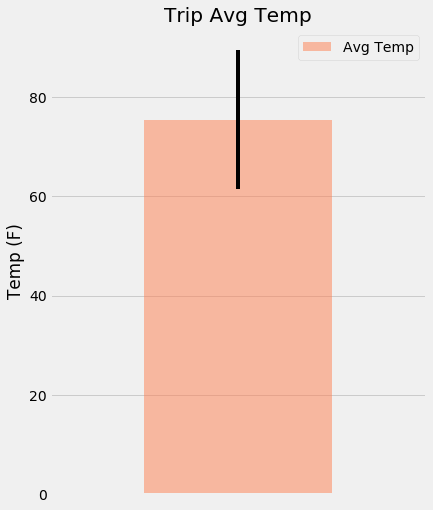

In [47]:
change = trip_df['Max Temp'] - trip_df['Min Temp']
avg_temp = trip_df['Avg Temp']
avg_temp.plot(kind = "bar",yerr=change, figsize=(6,8), alpha=0.5, color='coral')
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(True)
plt.title("Trip Avg Temp")
plt.legend()
plt.show()

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel_trip = [(Station.station).label("Station"), 
       (Station.name).label("Name"), 
       (Station.latitude).label("Latitude"), 
       (Station.longitude).label("Longitude"),
       (Station.elevation).label("Elevation"),
       (func.sum(Measurement.prcp).label("Total Rainfall"))]


my_trip = session.query(*sel_trip).\
                join(Measurement, Station.station == Measurement.station).\
                filter(Measurement.date >= '2015-06-15').\
                filter(Measurement.date <= '2015-06-30').\
                group_by(Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).\
                all()

my_trip


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.540000000000001),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.15),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.1400000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.42),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.22000000000000003),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.14)]